# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [420]:
import bson
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn import tree, ensemble
import sys
import time
import importlib

In [584]:
from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy


In [586]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    try:
        return namestr(df, globals())[0]
    except:
        return "Unknown"


## Load datasets and calculate scores

## Profile data

In [925]:
def remove_trailing_zero(id_):
    pattern = "([0-9]+)\\s+0"
    s = re.search(pattern, id_)
    if s:
        return s.group(1)
    return id_
id_path = PROJ_PATH + "/data/varol-2017.dat"
is_varol=True

id_df = pd.read_csv(id_path, sep='\t', names=("id_", "class"))

In [927]:
#def get_botometer_dataset_ids()
id_path = PROJ_PATH + "/data/cresci-stock-2018.tsv"
id_df = pd.read_csv(id_path, sep="\t", names=['id_', 'class'])
id_df.loc[:, 'id_'] = id_df['id_'].astype(str)

In [928]:
golbeck = pd.read_csv(PROJ_PATH + "/data/golbeck/AllScreennames.txt", names=('id_', 'screenname'))
golbeck['id_'] = golbeck['id_'].astype(str)
if is_varol:
    id_df['id_'] = id_df['id_'].map(remove_trailing_zero)
ids = set.intersection(set(id_df['id_']), set(golbeck['id_']))
avail = id_df.loc[id_df['id_'].isin(ids)]
if is_varol:
    avail.loc[:, 'class'].fillna(0, inplace=True)
labels = avail['class']
screennames = golbeck[golbeck['id_'].isin(ids)]

In [929]:
len(screennames)

13225

In [930]:
import os
not_found = 0
data_path = PROJ_PATH  + "/data/golbeck/tweets/"

for row in screennames.to_dict(orient='records'):
    tweets_path = data_path + f"{row['screenname']}_tweets.csv"
    print(tweets_path)
    if not os.path.exists(tweets_path):
        not_found += 1
    #tweets = pd.read_csv(tweets_path)

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/paynej247_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/LeveredLogic_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/AlertTrade_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/PennyStocksMomo_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ChartMill_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/diggingplatinum_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/IBDinvestors_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/EricPoulin9_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/KLRTRDR_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/QTRResearch_

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/j2v2g2SNzYoyDoQ_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ipcFyrYB2QSLJxZ_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/pnani456_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/BrandonCBibb_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/NelsonThought_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/JohnVieira25_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/TRISTANvsTEE_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/stockassassin74_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/MikeCintolo_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/OpenOutcrier_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Hypocrites_Oath_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/kevinjaybe_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ericsaroza_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/TMAN1138pm_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/adamfeuerstein_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Wolfmetric_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/BruceTennen_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/TomTerrarosa_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/tgler_tw

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Croustillan_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Corkizl_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/nianyi21_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/letrasblancas_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/giacomellisimon_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/lou_dog1017_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Keakush_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/hkearns4_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ASAPAlex___tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ASMEinc_tweets.csv
/nf

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/faithcharity7_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/kenziegordon7_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/LaurenRussell04_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/PoXVejVssbeznRj_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/paulalynngee_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Zorattaa_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/s4ilorprincess_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/yyy000112_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/rulesofdes_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/sco

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/josesousa_7_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/xue_cui_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Chuzzl3_fckk_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ps_lukas_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/kikucqua2_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/fenimoreone_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/SLyall_D_Bay_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/makiyo2617_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/AmberXGore_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/DrewBundy2016_tweets.c

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/ivansnet_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Xenomosity_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/meyerstone_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/CyberkillerNa_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/mylenaPB_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/xiaoguoji_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Guhstaavo__tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/budsman420_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/lovingniallll_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Shanyg293_tweets.csv


/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Ni_co_barto_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/bullchen88_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/imnflorida2_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/stushotspurs_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/erdalbl60571_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/haohaoxiao85_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Luna_Tix_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/neil_bigaouette_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/roldannicole_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/josealeja

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/FalconMatas_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/joesmithy8_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Sandra_wallgren_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/sweetdeerlulu_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/fatossobrehomem_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Lana_afaneh_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/WGfLow_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Velez_Jungle_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Racist_Randy_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/DavisJa

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/africa63_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Gtshaw55_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/CNBarber_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/AaronCB33_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/AaronSehlin_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/maratosatto_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Mel_Edwards34_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Gberg2119_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/SonOfMongolia_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/BriannaMonae_tweets.cs

/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/kass_boyce_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/A_SBurris_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/souwlaki_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/isaacssoto_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/acethepolarbear_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/LovelyJeenn_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/axgqz_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/km0ney35_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/Josh17Fair_tweets.csv
/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection/data/golbeck/tweets/bizzlexl_tweets.csv
/nfs/s

In [505]:
# Twibot
twibot_df, twibot_2020_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_2020_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_2020_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = set.intersection(set(twibot_2020_one_hot.columns), set(twibot_2020_one_hot_test.columns)) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_2020_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_2020_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(list(scr))
    
# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

#rtbust
rtbust, cresci_rtbust_2019_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(cresci_rtbust_2019_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_2017_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_2017_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(4)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci_2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci_2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci_2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci_2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee_2011, caverlee_2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee_2011_scores = analyze_bot_repo_dataset(caverlee_2011, caverlee_2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_2018_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_2018_one_hot, cresci_stock_labels, silent=True)


Starting kfold_cv at 09/27/22 09:49:02
Finished kfold_cv at 1664286542.5904977. Execution time: 0.09012436866760254 s
Starting kfold_cv at 09/27/22 09:49:02
Finished kfold_cv at 1664286542.6823819. Execution time: 0.09181690216064453 s
Starting kfold_cv at 09/27/22 09:49:02
Finished kfold_cv at 1664286542.7787557. Execution time: 0.09633064270019531 s
Starting kfold_cv at 09/27/22 09:49:02
Finished kfold_cv at 1664286542.876376. Execution time: 0.09755635261535645 s
Starting kfold_cv at 09/27/22 09:49:02
Finished kfold_cv at 1664286542.9763122. Execution time: 0.09988880157470703 s
Starting kfold_cv at 09/27/22 09:49:03
Finished kfold_cv at 1664286543.1064773. Execution time: 0.07672119140625 s
Starting kfold_cv at 09/27/22 09:49:03
Finished kfold_cv at 1664286543.184691. Execution time: 0.07816100120544434 s
Starting kfold_cv at 09/27/22 09:49:03
Finished kfold_cv at 1664286543.2663193. Execution time: 0.08158111572265625 s
Starting kfold_cv at 09/27/22 09:49:03
Finished kfold_cv at 1

In [696]:
def num_bots(labels):
    return sum(labels)

def num_humans(labels):
    return len(labels)-sum(labels)

In [715]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/pronbots-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
#verified
verified_df, verified_one_hot, verified_labels = load_bot_repo_dataset(PROJ_PATH + "/data/verified-2019_tweets.json", PROJ_PATH + "/data/verified-2019.tsv")

# EMD
ersahin_2017, ersahin_2017_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

In [32]:
midterm, midterm_2018_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_2018_one_hot, midterm_labels, kfold=False, silent=True)

Starting train_test_fit_and_score_clf at 09/26/22 15:50:08
Finished train_test_fit_and_score_clf at 1664221862.1924126. Execution time: 53.945799589157104 s
Starting train_test_fit_and_score_clf at 09/26/22 15:51:02
Finished train_test_fit_and_score_clf at 1664221919.6977499. Execution time: 57.505053758621216 s
Starting train_test_fit_and_score_clf at 09/26/22 15:51:59
Finished train_test_fit_and_score_clf at 1664221980.8586085. Execution time: 61.16074252128601 s
Starting train_test_fit_and_score_clf at 09/26/22 15:53:00
Finished train_test_fit_and_score_clf at 1664222045.678308. Execution time: 64.81957507133484 s
Starting train_test_fit_and_score_clf at 09/26/22 15:54:05
Finished train_test_fit_and_score_clf at 1664222114.707351. Execution time: 69.02893877029419 s


In [50]:
yang, yang_2013_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_2013_one_hot, yang_labels)

Starting kfold_cv at 09/26/22 16:10:13
Finished kfold_cv at 1664223033.933941. Execution time: 20.30891728401184 s
Starting kfold_cv at 09/26/22 16:10:33
Finished kfold_cv at 1664223057.4434118. Execution time: 23.50935459136963 s
Starting kfold_cv at 09/26/22 16:10:57
Finished kfold_cv at 1664223083.6972418. Execution time: 26.253708124160767 s
Starting kfold_cv at 09/26/22 16:11:23
Finished kfold_cv at 1664223112.8065372. Execution time: 29.109019994735718 s
Starting kfold_cv at 09/26/22 16:11:52
Finished kfold_cv at 1664223143.8624747. Execution time: 31.055654525756836 s


## Tweets data

In [7]:
yang_tweets, yang_2013_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_2013_tweets_labels)


Starting kfold_cv at 09/26/22 09:57:27
Finished kfold_cv at 1664200669.7532294. Execution time: 22.242379426956177 s
Starting kfold_cv at 09/26/22 09:57:49
Finished kfold_cv at 1664200703.8283837. Execution time: 34.075021743774414 s
Starting kfold_cv at 09/26/22 09:58:23
Finished kfold_cv at 1664200749.6626039. Execution time: 45.83409595489502 s
Starting kfold_cv at 09/26/22 09:59:09
Finished kfold_cv at 1664200807.2075627. Execution time: 57.544682025909424 s
Starting kfold_cv at 09/26/22 10:00:07
Finished kfold_cv at 1664200876.0739362. Execution time: 68.86609077453613 s


In [33]:
pan_2019_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan_2019_df, pan19_labels)


Starting kfold_cv at 09/26/22 15:55:21
Finished kfold_cv at 1664222126.7220337. Execution time: 4.795443058013916 s
Starting kfold_cv at 09/26/22 15:55:26
Finished kfold_cv at 1664222133.6101258. Execution time: 6.887970924377441 s
Starting kfold_cv at 09/26/22 15:55:33
Finished kfold_cv at 1664222142.518567. Execution time: 8.908321857452393 s
Starting kfold_cv at 09/26/22 15:55:42
Finished kfold_cv at 1664222153.3741643. Execution time: 10.855479717254639 s
Starting kfold_cv at 09/26/22 15:55:53
Finished kfold_cv at 1664222166.1924815. Execution time: 12.81803035736084 s


In [9]:
cresci_2017_tweets, cresci_2017_tweets_labels = load_cresci_2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci_2017_tweets_scores = analyze_bot_repo_dataset(cresci_2017_tweets, cresci_2017_tweets_labels, kfold=False, silent=True)


/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
cresci_2015_tweets, cresci_2015_tweets_labels = load_cresci_2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci_2015_tweets_scores = analyze_bot_repo_dataset(cresci_2015_tweets, cresci2015_labels)


/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Starting kfold_cv at 09/26/22 10:06:14
Finished kfold_cv at 1664201197.7768464. Execution time: 22.864714860916138 s
Starting kfold_cv at 09/26/22 10:06:37
Finished kfold_cv at 1664201231.762884. Execution time: 33.98591375350952 s
Starting kfold_cv at 09/26/22 10:07:11
Finished kfold_cv at 1664201273.1124325. Execution time: 41.34924340248108 s
Starting kfold_cv at 09/26/22 10:07:53
Finished kfold_cv at 1664201318.81692. Execution time: 45.7042019367218 s
Starting kfold_cv at 09/26/22 10:08:38
Finished kfold_cv at 1664201370.6130238. Execution time: 51.795817375183105 s


In [11]:
cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels = load_cresci_stock_2018_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_2018_tweets_scores = analyze_bot_repo_dataset(cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels)


Starting kfold_cv at 09/26/22 10:17:44
Finished kfold_cv at 1664202082.7906985. Execution time: 217.94106674194336 s
Starting kfold_cv at 09/26/22 10:21:22
Finished kfold_cv at 1664202432.0418336. Execution time: 349.2509913444519 s
Starting kfold_cv at 09/26/22 10:27:12
Finished kfold_cv at 1664202902.3017054. Execution time: 470.25959300994873 s
Starting kfold_cv at 09/26/22 10:35:02
Finished kfold_cv at 1664203481.2730486. Execution time: 578.9710657596588 s
Starting kfold_cv at 09/26/22 10:44:41
Finished kfold_cv at 1664204164.126355. Execution time: 682.853030204773 s


In [938]:
scores = {
    'twibot-2020': twibot_scores, 
    'botometer-feedback-2019': botometer_feedback_scores, 
    'cresci-rtbust-2019': rtbust_scores, 
    'gilani-2017': gilani_derived_scores_avg, 
    'cresci-2017': cresci2017_scores, 
    'cresci-2015': cresci2015_scores, 
    'caverlee-2011': caverlee_2011_scores,
    'midterm-2018': midterm_scores, 
    'pan-2019': pan19_scores
}

rows = []

for name, scr in scores.items():
    row = {'name': name}
    for i, (a,p,r,f) in enumerate(scr):
        row.update({
            f'a{i+1}': a,
            f'p{i+1}': p,
            f'r{i+1}': r,
            f'f{i+1}': f,
        })
    rows.append(row)
scores_df = pd.DataFrame(rows)
scores_df.to_csv("scores.csv", index=False)

In [933]:
kantepe_path = PROJ_PATH + "/data/kantepe-2017/user.bson"

with open(kantepe_path,'rb') as f:
    data = bson.decode_all(f.read())
    kantepe = pd.DataFrame(data)

In [937]:
kantepe.loc[0]['user']

{'id': 818005529855479808,
 'name': 'SHATER',
 'screenName': 'django3x',
 'description': 'İmam Hatipler Kapatılsın',
 'descriptionURLEntities': [],
 'isContributorsEnabled': False,
 'profileImageUrl': 'http://pbs.twimg.com/profile_images/818023444881219584/99Ouhqhl_normal.jpg',
 'profileImageUrlHttps': 'https://pbs.twimg.com/profile_images/818023444881219584/99Ouhqhl_normal.jpg',
 'isDefaultProfileImage': False,
 'isProtected': False,
 'followersCount': 265,
 'profileBackgroundColor': 'F5F8FA',
 'profileTextColor': '333333',
 'profileLinkColor': '1DA1F2',
 'profileSidebarFillColor': 'DDEEF6',
 'profileSidebarBorderColor': 'C0DEED',
 'profileUseBackgroundImage': True,
 'isDefaultProfile': True,
 'showAllInlineMedia': False,
 'friendsCount': 3761,
 'createdAt': 'Jan 8, 2017 11:04:50 AM',
 'favouritesCount': 3480,
 'utcOffset': -1,
 'profileBackgroundImageUrl': '',
 'profileBackgroundImageUrlHttps': '',
 'profileBannerImageUrl': 'https://pbs.twimg.com/profile_banners/818005529855479808/14

In [672]:
import pyreadr

kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']

In [673]:
kaiser

,user.id_str,date,type,cap.universal,scores.universal
0,1073515275323097088,2019-03-03,bot,0.325413,0.724840
1,961438005675397120,2019-03-03,bot,0.104603,0.515643
2,941291900862124032,2019-03-03,bot,0.060559,0.413570
3,809439447796355072,2019-03-03,bot,0.060559,0.413570
4,769777732213321729,2019-03-03,bot,0.054305,0.393746
...,...,...,...,...,...
374719,2234767742,2019-06-02,ger_bot,0.104603,0.515643
374720,1092190045,2019-06-02,ger_bot,0.010165,0.170132
374721,57146860,2019-06-02,ger_bot,0.023812,0.267344
374722,56828167,2019-06-02,ger_bot,0.005778,0.119570


# Train on one, test on another

In [526]:
datasets = [twibot_2020_one_hot, botometer_feedback_2019_one_hot, cresci_rtbust_2019_one_hot, gilani_2017_one_hot, cresci_2017_one_hot, cresci_2015_one_hot, cresci_stock_2018_one_hot, yang_2013_one_hot]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]

def train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, silent=True):
    cols = ([e for e in list(train_on) if e in list(test_on)])
    #print(cols)
    scores = {
        'train_on': get_dataset_name(train_on),
        'test_on': get_dataset_name(test_on),
    }
    for i in range(1,6):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, silent=True)

        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
    if not silent:
        print(f"trained on: {get_dataset_name(train_on)}, tested on: {get_dataset_name(test_on)}, acc: {a:.2}, prec: {p:.2}, recall: {r:.2}, f1: {f:.2}, test bot freq: {np.round_(prop_bots,2)}")

    return scores   
            

In [527]:
rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels))
        
train_on_one_test_on_another_performance = pd.DataFrame(rows)  

/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

In [751]:
def process_tick_label(tick_label):
    ret = tick_label
    if tick_label.endswith('_one_hot'):
        ret = tick_label[:-8]
    if tick_label.endswith("_df"):
        ret = tick_label[:-3]
    return ret.replace('_', '-')

def heatmap_train_on_one_test_on_another(df, metric_name, depth):    
    tick_labels = df['train_on'].unique()

    d = len(tick_labels)
    data = [[] for i in range(d)]
    for i in range(d):
        for j in range(d):
            metric = df[(df['train_on'] == tick_labels[i]) & (df['test_on'] == tick_labels[j])]
            if metric_name == "accuracy":
                metric = metric[f'a{depth}'].values[0]
            if metric_name == "f1":
                metric = metric[f'f{depth}'].values[0]
            data[i].append(metric)

    data = np.array(data)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data, cmap="RdYlGn")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels([process_tick_label(t) for t in tick_labels])
    ax.set_yticks(np.arange(len(tick_labels)))
    ax.set_yticklabels([process_tick_label(t) for t in tick_labels])
    #ax.spines.set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    d = len(tick_labels)
    for i in range(d):
        for j in range(d):
            metric = data[i][j]
            text = ax.text(j, i, f"{metric:.2f}",
                           ha="center", va="center")



    ax.set_title(f"Train on one test on another: {metric_name}, depth={depth}")
    fig.tight_layout()
    plt.savefig(f"trainononetestonanother_{metric_name}.svg")
    plt.show()
    return pd.DataFrame(tootoa_a3, index=tick_labels, columns=tick_labels)

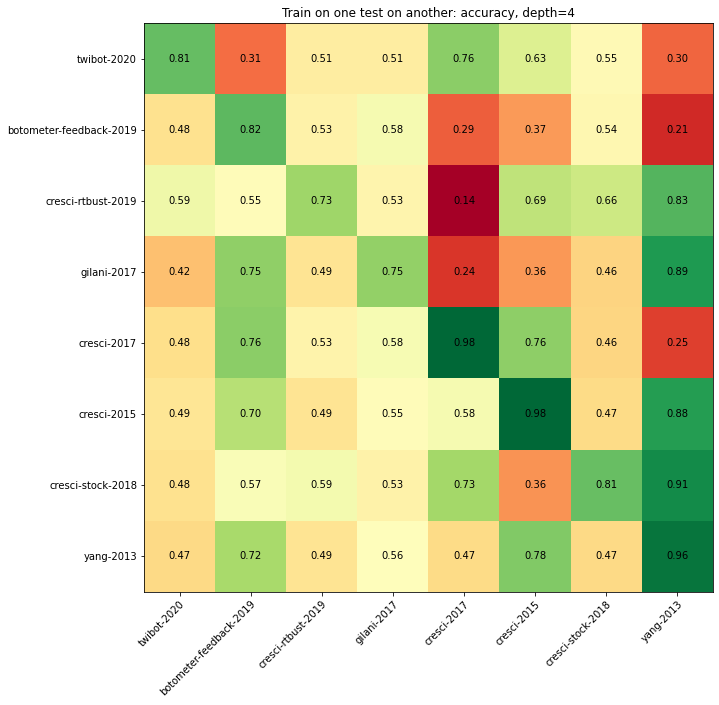

In [760]:
depth=4
tootoa_a3 = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'accuracy', depth)
tootoa_a3.to_csv(f"tootoa_a{depth}.csv")

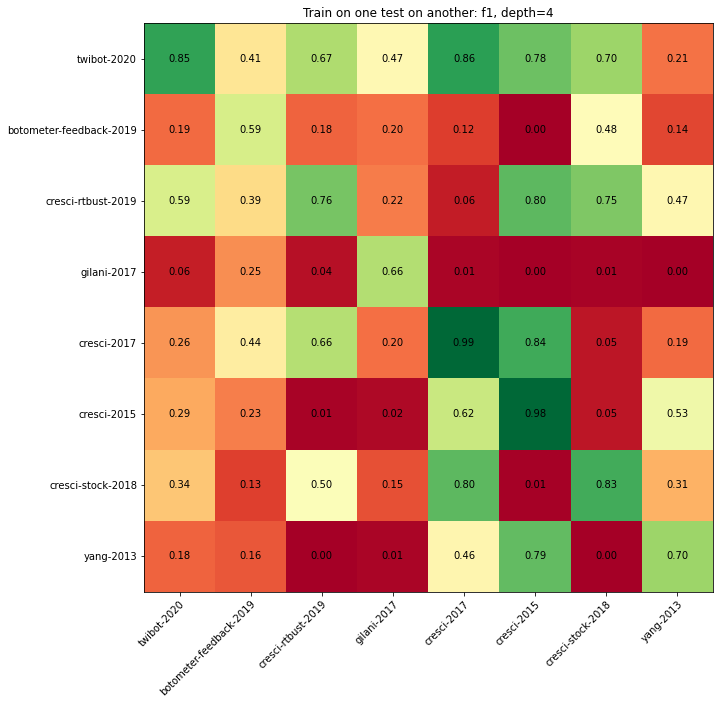

In [761]:
depth=4
tootoa_f = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'f1', depth)
tootoa_f.to_csv(f"tootoa_f{depth}.csv")

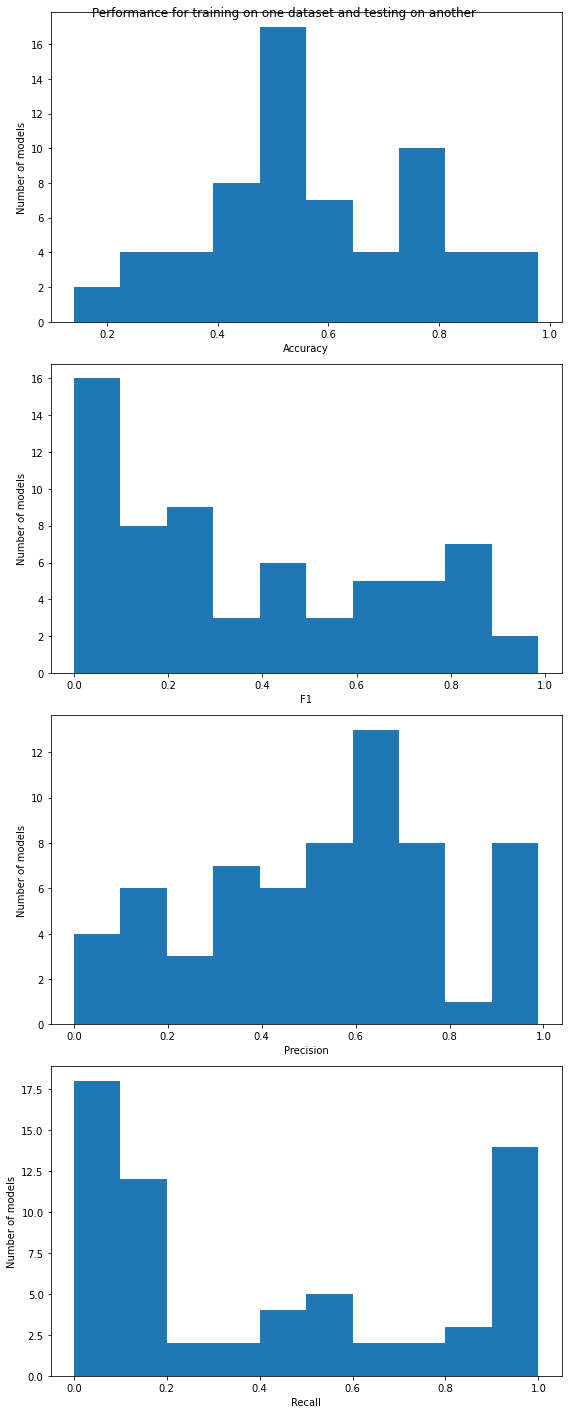

In [23]:
def hist_train_on_one_test_on_another(performance_df):
    fig, axes = plt.subplots(4, 1, figsize=(8,20))
    max_depth = 5

    accs = []
    fs = []
    precs = []
    recs = []


    for ind, row in performance_df.iterrows():
        metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
        accs.append(max(metric_a))

        metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
        fs.append(max(metric_f))


        metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
        precs.append(max(metric_p))


        metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
        recs.append(max(metric_r))


    axes[0].hist(accs)
    axes[1].hist(fs)
    axes[2].hist(precs)
    axes[3].hist(recs)


    axes[0].set_xlabel("Accuracy")
    axes[1].set_xlabel("F1")
    axes[2].set_xlabel("Precision")
    axes[3].set_xlabel("Recall")

    axes[0].set_ylabel("Number of models")
    axes[1].set_ylabel("Number of models")
    axes[2].set_ylabel("Number of models")
    axes[3].set_ylabel("Number of models")

    #axes[0].legend(loc='lower left')
    fig.suptitle("Performance for training on one dataset and testing on another")
    fig.tight_layout()
    plt.show()
    
hist_train_on_one_test_on_another(train_on_one_test_on_another_performance)

# Leave-one-dataset-out

In [29]:
cols = list(set.intersection(*map(set,[list(d) for d in datasets])))
max_depth = 5

def leave_dataset_out(i):
    
    use_datasets = datasets[:i] + datasets[i+1:]
    use_labels = labels[:i] + labels[i+1:]

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on = pd.concat([d[cols] for d in use_datasets])
    train_on_labels = pd.concat([pd.Series(d) for d in use_labels])
        
    test_on = datasets[i][cols]
    test_on_labels = labels[i]
    
    for j in range(1,max_depth+1):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, depth=j, silent=True)
        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores

rows = []

for i in range(len(datasets)):
    rows.append(leave_dataset_out(i))
    
leave_one_out_scores = pd.DataFrame(rows)

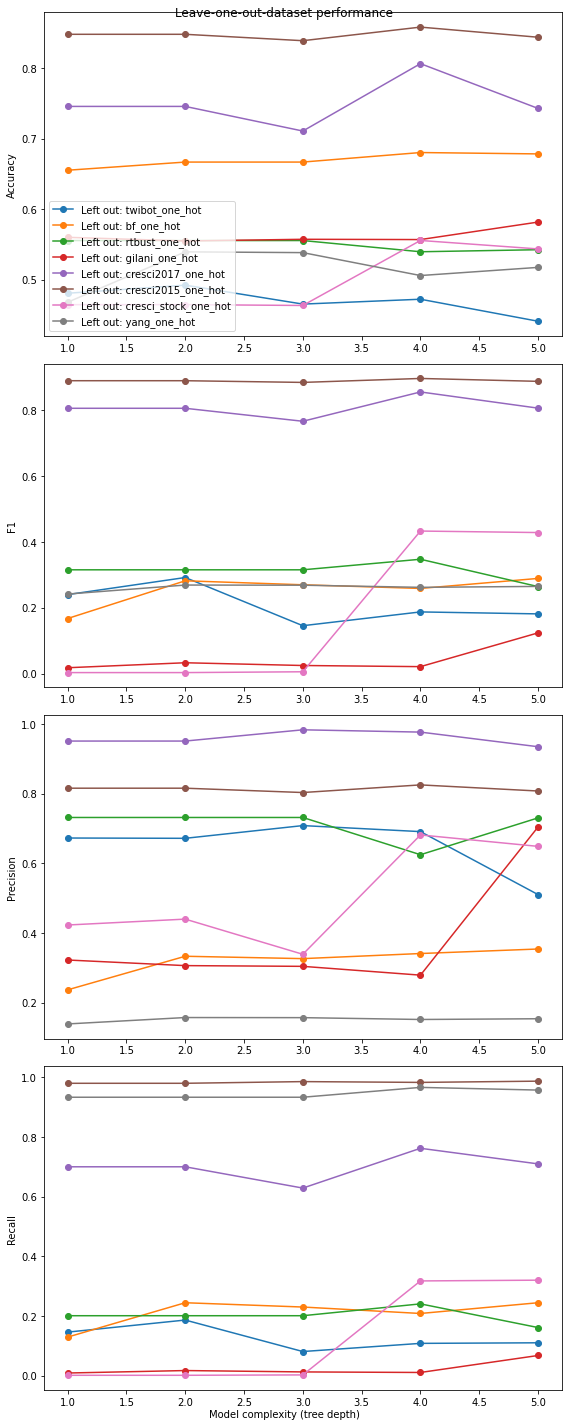

In [28]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

In [558]:
def print_leave_one_out_table(df):
    max_depth = 5
    tolerance = 0.025

    for row in df.to_dict(orient='records'):
        k = row['left_out']
        if k == 'varol-2017':
            continue

        accuracies = [row[f'a{i}'] for i in range(1, max_depth+1)]
        a_max_ind = np.argmax(accuracies)
        f1s = [row[f'f{i}'] for i in range(1, max_depth+1)]
        f_max_ind = np.argmax(f1s)
        accuracy_sdt = accuracies[a_max_ind]
        f1_sdt = f1s[f_max_ind]

        for i, acc in enumerate(accuracies):
            if accuracy_sdt - acc <= tolerance:
                a_max_ind = i
                accuracy_sdt = acc
                break
        for i, f in enumerate(f1s):
            if f1_sdt - f <= tolerance:
                f_max_ind = i
                f1_sdt = acc
                break

        print(f"{k} & {accuracy_sdt:0.2f}" \
              + " \\textit{" \
              + f"({a_max_ind+1})" \
              + "} & " \
              + f"{f1_sdt:0.2f} " \
              " \\textit{" \
              + f"({f_max_ind+1})" \
              + "} \\\\"
             )

In [82]:
print_leave_one_out_table(leave_one_out_scores)

twibot_one_hot & 0.48 \textit{(1)} & 0.48  \textit{(2)} \\
bf_one_hot & 0.67 \textit{(2)} & 0.67  \textit{(2)} \\
rtbust_one_hot & 0.56 \textit{(1)} & 0.56  \textit{(4)} \\
gilani_one_hot & 0.56 \textit{(1)} & 0.56  \textit{(5)} \\
cresci2017_one_hot & 0.81 \textit{(4)} & 0.81  \textit{(4)} \\
cresci2015_one_hot & 0.85 \textit{(1)} & 0.85  \textit{(1)} \\
cresci_stock_one_hot & 0.56 \textit{(4)} & 0.56  \textit{(4)} \\
yang_one_hot & 0.54 \textit{(2)} & 0.54  \textit{(2)} \\


## Analysis of each of the specialized classifiers in Botometer

In [635]:
def get_columns(df):
    return df.columns[~df.columns.str.contains('location') & ~df.columns.str.contains('utc') & ~df.columns.str.contains('time_zone')& ~df.columns.str.contains('lang')]


### humans

In [636]:
caverlee_2011.set_axis(['created_at', 'friends_count', 'followers_count', 'statuses_count', 'LengthfScreenName', 'LengthOfDescriptionInUserProfile'], inplace=True, axis=1)

caverlee2011_humans = caverlee_2011[caverlee_2011_labels.values == 0]
botometer_feedback_2019_one_hot_humans = botometer_feedback_2019_one_hot[bf_labels.values == 0]
gilani_2017_one_hot_humans = gilani_2017_one_hot[gilani_labels.values == 0]
cresci_rtbust_2019_one_hot_humans = cresci_rtbust_2019_one_hot[rtbust_labels.values == 0]
cresci_stock_2018_one_hot_humans = cresci_stock_2018_one_hot[cresci_stock_labels.values == 0]
midterm_2018_one_hot_humans = midterm_2018_one_hot[midterm_labels.values == 0]

cols = set.intersection(
    set(celebrity_one_hot.columns),
    set(botometer_feedback_2019_one_hot_humans.columns),
    set(caverlee2011_humans.columns),
    set(gilani_2017_one_hot_humans.columns),
    set(cresci_stock_2018_one_hot_humans.columns),
                       )

human_df = pd.concat([
    caverlee2011_humans[cols], 
    botometer_feedback_2019_one_hot_humans[cols],
    celebrity_one_hot[cols],
    gilani_2017_one_hot_humans[cols],
    cresci_stock_2018_one_hot_humans[cols],
    celebrity_one_hot[cols]
], axis=0)

### simple bots

In [637]:
caverlee2011_bots = caverlee_2011[caverlee_2011_labels.values == 1]
simple_df = caverlee2011_bots

In [638]:
simple_df.columns

Index(['created_at', 'friends_count', 'followers_count', 'statuses_count',
       'LengthfScreenName', 'LengthOfDescriptionInUserProfile'],
      dtype='object')

### spammers

In [639]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 1, 1, 1, 1, 1, 1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at',
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
# cresci2017_spammers_one_hot.loc[:,~cresci2017_spammers_one_hot.columns.duplicated()]
# pronbots_one_hot = pronbots_one_hot.loc[:,~pronbots_one_hot.columns.duplicated()]
# pronbots_one_hot = pronbots_one_hot.drop(['location'])
cols = set(pronbots_one_hot.columns).intersection(set(cresci2017_spammers_one_hot.columns))
spammers_df = pd.concat([pronbots_one_hot[cols], cresci2017_spammers_one_hot[cols]])


In [640]:
get_columns(spammers_df)

Index(['friends_count', 'statuses_count', 'listed_count', 'followers_count',
       'favourites_count'],
      dtype='object')

### fake followers

In [641]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))
fake_followers_df = pd.concat([vendor_purchased_one_hot, cresci2017_fake_followers_one_hot[cols]])


In [642]:
fake_followers_df.columns[~fake_followers_df.columns.str.contains('location') & ~fake_followers_df.columns.str.contains('utc') & ~fake_followers_df.columns.str.contains('time_zone')& ~fake_followers_df.columns.str.contains('lang')]


Index(['followers_count', 'listed_count', 'statuses_count', 'friends_count',
       'favourites_count', 'created_at', 'default_profile_True',
       'default_profile_image_True', 'profile_background_tile_True',
       'geo_enabled_True', 'verified_True',
       'profile_use_background_image_True', 'is_translation_enabled_True',
       'has_extended_profile_True'],
      dtype='object')

### self-declared

In [643]:
self_declared_df = botwiki_one_hot

get_columns(self_declared_df)

Index(['followers_count', 'friends_count', 'listed_count', 'created_at',
       'favourites_count', 'statuses_count', 'default_profile_True',
       'default_profile_image_True', 'default_profile_True',
       'default_profile_image_True', 'profile_background_tile_True',
       'geo_enabled_True', 'verified_True',
       'profile_use_background_image_True', 'is_translation_enabled_True',
       'has_extended_profile_True'],
      dtype='object')

### political bots

In [644]:
political_bots_df = political_bots_one_hot

get_columns(political_bots_df)

Index(['followers_count', 'listed_count', 'statuses_count', 'friends_count',
       'favourites_count', 'created_at', 'default_profile_True',
       'default_profile_True', 'profile_background_tile_True',
       'geo_enabled_True'],
      dtype='object')

### other bots

In [645]:
botometer_feedback_2019_one_hot_bot = botometer_feedback_2019_one_hot[bf_labels.values == 1]
gilani_2017_one_hot_bot = gilani_2017_one_hot[gilani_labels.values == 1]
cresci_rtbust_2019_one_hot_bot = cresci_rtbust_2019_one_hot[rtbust_labels.values == 1]
cresci_stock_2018_one_hot_bot = cresci_stock_2018_one_hot[cresci_stock_labels.values == 1]
midterm_2018_one_hot_bot = midterm_2018_one_hot[midterm_labels.values == 1]

cols = set.intersection(
    set(botometer_feedback_2019_one_hot_bot.columns), 
    set(gilani_2017_one_hot_bot.columns), 
    set(cresci_rtbust_2019_one_hot_bot.columns), 
    set(cresci_stock_2018_one_hot_bot.columns), 
)

other_bots = pd.concat([botometer_feedback_2019_one_hot_bot[cols], 
                        gilani_2017_one_hot_bot[cols], 
                        cresci_rtbust_2019_one_hot_bot[cols], 
                        cresci_stock_2018_one_hot_bot[cols]])


In [646]:
get_columns(other_bots)

Index(['default_profile_image_True', 'default_profile_image_True',
       'friends_count', 'listed_count', 'verified_True',
       'is_translation_enabled_True', 'has_extended_profile_True',
       'created_at', 'followers_count', 'profile_use_background_image_True',
       'default_profile_True', 'default_profile_True', 'statuses_count',
       'geo_enabled_True', 'favourites_count', 'profile_background_tile_True'],
      dtype='object')

# Botometer combined datasets: train on one, test on same one

In [647]:

def train_test_botometer_combined(bots, humans, silent=True):
    np.random.seed(1)
    dataset_size = min(len(bots), len(humans))
    n=min(dataset_size, 1000)
    
    cols = set.intersection(
        set(bots.columns),
        set(humans.columns)
    )
    if 'created_at' in cols:
        cols.remove('created_at')
    cols = list(cols)
    
    X = pd.concat([bots.sample(n=n)[cols], humans.sample(n=n)[cols]])
    y = [1] * n + [0] * n
        
    X = X.fillna(0)
        
    scores = {
        'dataset': get_dataset_name(bots),
    }
    
    for i in range(1, max_depth+1):
        a,p,r,f = train_test_fit_and_score(X, y, depth=i, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores
        

In [648]:
# human_cols = set.intersection(
#     set(celebrity_one_hot.columns),
#     set(botometer_feedback_2019_one_hot_humans.columns),
#     set(gilani_2017_one_hot_humans.columns),
#     set(cresci_stock_2018_one_hot_humans.columns),
#                        )

# human_df = pd.concat([
#     botometer_feedback_2019_one_hot_humans[cols],
#     celebrity_one_hot[cols],
#     gilani_2017_one_hot_humans[cols],
#     cresci_stock_2018_one_hot_humans[cols],
#     celebrity_one_hot[cols]
# ], axis=0)

botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]

#botometer_datasets = [spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
rows = []
for j, dataset in enumerate(botometer_datasets[0:]):
    print(get_dataset_name(dataset))
    rows.append(train_test_botometer_combined(dataset, human_df, silent=False))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

caverlee2011_bots
Starting train_test_fit_and_score_clf at 09/27/22 14:51:59
|--- statuses_count <= 280.50
|   |--- weights: [130.00, 524.00] class: 1
|--- statuses_count >  280.50
|   |--- weights: [663.00, 283.00] class: 0

Accuracy: 0.7025
Precision 0.725609756097561
Recall: 0.616580310880829
F1: 0.6666666666666666
Finished train_test_fit_and_score_clf at 1664304719.5580692. Execution time: 0.04586076736450195 s
Starting train_test_fit_and_score_clf at 09/27/22 14:51:59
|--- statuses_count <= 276.50
|   |--- friends_count <= 88.00
|   |   |--- weights: [110.00, 43.00] class: 0
|   |--- friends_count >  88.00
|   |   |--- weights: [26.00, 472.00] class: 1
|--- statuses_count >  276.50
|   |--- friends_count <= 1109.50
|   |   |--- weights: [574.00, 86.00] class: 0
|   |--- friends_count >  1109.50
|   |   |--- weights: [87.00, 202.00] class: 1

Accuracy: 0.8175
Precision 0.8297872340425532
Recall: 0.7918781725888325
F1: 0.8103896103896104
Finished train_test_fit_and_score_clf at 1664

|--- statuses_count <= 189.50
|   |--- weights: [112.00, 723.00] class: 1
|--- statuses_count >  189.50
|   |--- weights: [692.00, 73.00] class: 0

Accuracy: 0.8675
Precision 0.883248730964467
Recall: 0.8529411764705882
F1: 0.8678304239401496
Finished train_test_fit_and_score_clf at 1664304719.7156506. Execution time: 0.021416902542114258 s
Starting train_test_fit_and_score_clf at 09/27/22 14:51:59
|--- statuses_count <= 154.50
|   |--- friends_count <= 0.50
|   |   |--- weights: [10.00, 432.00] class: 1
|   |--- friends_count >  0.50
|   |   |--- weights: [85.00, 274.00] class: 1
|--- statuses_count >  154.50
|   |--- statuses_count <= 450.00
|   |   |--- weights: [84.00, 52.00] class: 0
|   |--- statuses_count >  450.00
|   |   |--- weights: [618.00, 45.00] class: 0

Accuracy: 0.89
Precision 0.8963730569948186
Recall: 0.8781725888324873
F1: 0.8871794871794872
Finished train_test_fit_and_score_clf at 1664304719.7368064. Execution time: 0.021114587783813477 s
Starting train_test_fit_an

|--- statuses_count <= 117.50
|   |--- friends_count <= 133.00
|   |   |--- statuses_count <= 6.50
|   |   |   |--- friends_count <= 12.50
|   |   |   |   |--- weights: [11.00, 0.00] class: 0
|   |   |   |--- friends_count >  12.50
|   |   |   |   |--- statuses_count <= 5.00
|   |   |   |   |   |--- weights: [0.00, 29.00] class: 1
|   |   |   |   |--- statuses_count >  5.00
|   |   |   |   |   |--- weights: [1.00, 1.00] class: 0
|   |   |--- statuses_count >  6.50
|   |   |   |--- followers_count <= 1.50
|   |   |   |   |--- friends_count <= 44.50
|   |   |   |   |   |--- weights: [6.00, 0.00] class: 0
|   |   |   |   |--- friends_count >  44.50
|   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |--- followers_count >  1.50
|   |   |   |   |--- friends_count <= 0.50
|   |   |   |   |   |--- weights: [6.00, 1.00] class: 0
|   |   |   |   |--- friends_count >  0.50
|   |   |   |   |   |--- weights: [61.00, 0.00] class: 0
|   |--- friends_count >  133.00
|   |   |--- foll

|--- followers_count <= 28.50
|   |--- statuses_count <= 302.50
|   |   |--- weights: [99.00, 58.00] class: 0
|   |--- statuses_count >  302.50
|   |   |--- weights: [25.00, 370.00] class: 1
|--- followers_count >  28.50
|   |--- friends_count <= 6.50
|   |   |--- weights: [28.00, 91.00] class: 1
|   |--- friends_count >  6.50
|   |   |--- weights: [646.00, 283.00] class: 0

Accuracy: 0.74
Precision 0.8671875
Recall: 0.5606060606060606
F1: 0.6809815950920245
Finished train_test_fit_and_score_clf at 1664304720.137694. Execution time: 0.020601272583007812 s
Starting train_test_fit_and_score_clf at 09/27/22 14:52:00
|--- followers_count <= 40.50
|   |--- statuses_count <= 743.50
|   |   |--- friends_count <= 0.50
|   |   |   |--- weights: [20.00, 67.00] class: 1
|   |   |--- friends_count >  0.50
|   |   |   |--- weights: [129.00, 37.00] class: 0
|   |--- statuses_count >  743.50
|   |   |--- followers_count <= 29.50
|   |   |   |--- weights: [7.00, 327.00] class: 1
|   |   |--- followers

In [649]:
botometer_leave_one_out_scores

,dataset,a1,p1,r1,f1,a2,p2,r2,f2,a3,...,r3,f3,a4,p4,r4,f4,a5,p5,r5,f5
0,caverlee2011_bots,0.7025,0.725610,0.616580,0.666667,0.817500,0.829787,0.791878,0.810390,0.895000,...,0.888889,0.897561,0.895000,0.923445,0.881279,0.901869,0.917500,0.893805,0.957346,0.924485
1,spammers_df,0.8675,0.883249,0.852941,0.867830,0.890000,0.896373,0.878173,0.887179,0.907500,...,0.917476,0.910843,0.897500,0.935484,0.857143,0.894602,0.917500,0.907692,0.921875,0.914729
2,fake_followers_df,0.8800,0.879581,0.870466,0.875000,0.880000,0.987654,0.776699,0.869565,0.900000,...,0.901961,0.901961,0.955000,0.925000,0.984043,0.953608,0.937500,0.938389,0.942857,0.940618
3,botwiki_one_hot,0.8500,0.905983,0.773723,0.834646,0.857143,0.963964,0.748252,0.842520,0.939286,...,0.930070,0.939929,0.892857,0.915385,0.862319,0.888060,0.896429,0.895833,0.902098,0.898955
4,political_bots_df,0.9200,0.909091,0.909091,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.960000,0.875000,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000
5,other_bots,0.6925,0.733333,0.637681,0.682171,0.740000,0.867188,0.560606,0.680982,0.767500,...,0.892308,0.789116,0.797500,0.851613,0.694737,0.765217,0.802500,0.854651,0.731343,0.788204


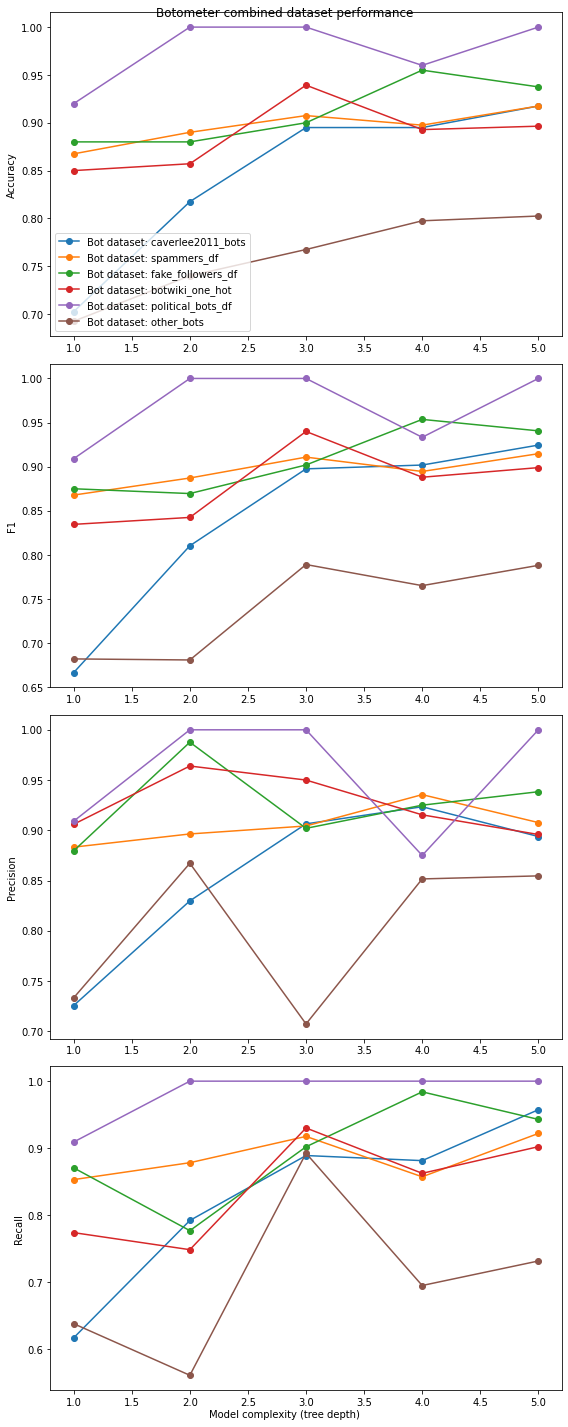

In [650]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Bot dataset: {row['dataset']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"{row['dataset']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"{row['dataset']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"{row['dataset']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer combined dataset performance")
fig.tight_layout()
plt.show()

# Botometer combined datasets: train on one, test on another

In [651]:
def train_on_one_test_on_another_botometer_combined(bots1, bots2, humans, silent=True):
    dataset_size = min(len(bots1), len(bots2), len(humans))
    bot1_inds = np.random.permutation(dataset_size)
    human1_inds = np.random.permutation(dataset_size)
    
    bot2_inds = np.random.permutation(dataset_size)
    human2_inds = np.random.permutation(dataset_size)
    
    cols = set.intersection(
        set(bots1.columns),
        set(bots2.columns),
        set(humans.columns)
    )
    if 'created_at' in cols:
        cols.remove('created_at')
    
    train_on = pd.concat([bots1.iloc[bot1_inds][cols], humans.iloc[human1_inds][cols]])
    train_on_labels = [1] * dataset_size + [0] * dataset_size
    train_on = train_on[cols].fillna(0)
    
    test_on = pd.concat([bots2.iloc[bot2_inds][cols], humans.iloc[human2_inds][cols]])
    test_on_labels = [1] * dataset_size + [0] * dataset_size
    test_on = test_on[cols].fillna(0)
    
    
    scores = {
        'train_on': get_dataset_name(bots1),
        'test_on': get_dataset_name(bots2),
    }
    
    for i in range(1, max_depth+1):
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=i, silent=silent)
        a,p,r,f = score(clf, test_on, test_on_labels, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores


In [652]:
rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
#         if (get_dataset_name(bots1) == get_dataset_name(bots2)):
#             continue
        #print(get_dataset_name(bots1), get_dataset_name(bots2))
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, bots2, human_df, silent=True))
        
botometer_train_on_one_test_on_another_performance = pd.DataFrame(rows)   


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

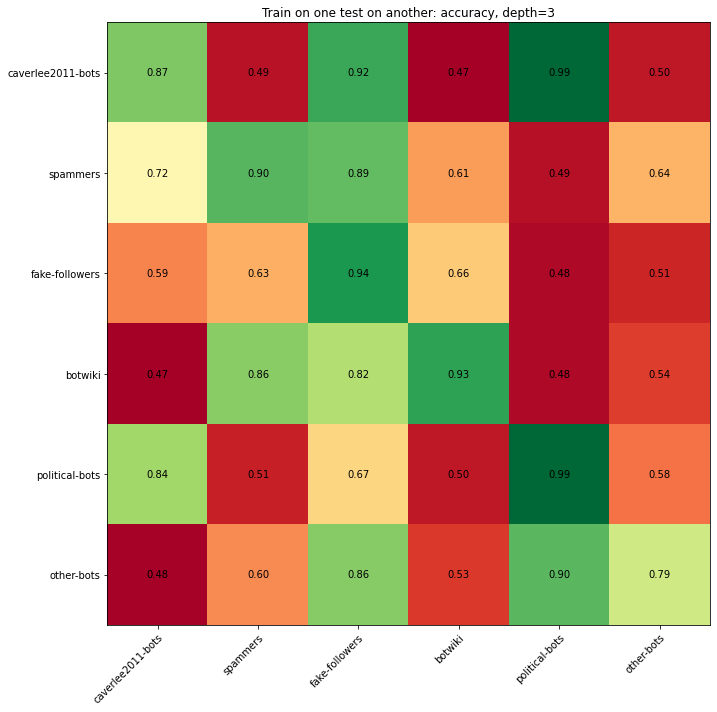

In [762]:
depth = 3
botometer_tootoa_a = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'accuracy', depth)
botometer_tootoa_a.to_csv(f"botometer_tootoa_a{depth}.csv")

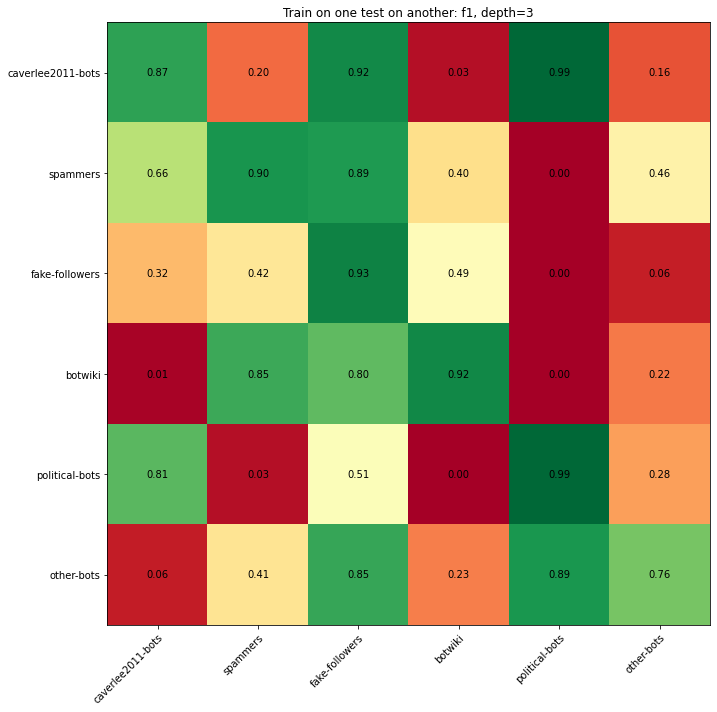

In [763]:
depth = 3
botometer_tootoa_f = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'f1', depth)
botometer_tootoa_f.to_csv(f"botometer_tootoa_f{depth}.csv")

# Botometer combined datasets: leave-one-dataset-out

In [655]:
cols = list(set.intersection(*map(set,[list(d) for d in botometer_datasets])))
if 'created_at' in cols:
    cols.remove("created_at")
max_depth = 5
n = 1000
def botometer_leave_dataset_out(datasets, i):
    use_datasets = datasets[:i] + datasets[i+1:]
    num_bots = sum([len(d) for d in datasets[:i]]) + sum([len(d) for d in datasets[i+1:]])
    
    dataset_size = min(num_bots, len(datasets[i]), len(human_df))
    
    bot_train_inds = np.random.permutation(n)
    human_train_inds = np.random.permutation(n)
    
    bot_test_inds = np.random.permutation(dataset_size)
    human_test_inds = np.random.permutation(dataset_size)
    

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on_bots = pd.concat([d[cols] for d in use_datasets]).iloc[bot_train_inds]
    train_on = pd.concat([train_on_bots, human_df.iloc[human_train_inds][cols]])
    train_on_labels = [1]*n + [0]*n
    train_on = train_on.fillna(0)

        
    test_on_bots = datasets[i][cols].iloc[bot_test_inds]
    test_on = pd.concat([test_on_bots, human_df.iloc[human_test_inds][cols]])
    test_on_labels = [1]*dataset_size + [0]*dataset_size
    test_on = test_on.fillna(0)

    
    for j in range(1,max_depth+1):
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=j, silent=True)
        a,p,r,f = (score(clf, test_on, test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores

rows = []

for i in range(len(botometer_datasets)):
    rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

In [656]:
print_leave_one_out_table(botometer_leave_one_out_scores)

caverlee2011_bots & 0.70 \textit{(3)} & 0.70  \textit{(1)} \\
spammers_df & 0.81 \textit{(2)} & 0.81  \textit{(2)} \\
fake_followers_df & 0.92 \textit{(3)} & 0.92  \textit{(3)} \\
botwiki_one_hot & 0.46 \textit{(1)} & 0.46  \textit{(2)} \\
political_bots_df & 0.96 \textit{(3)} & 0.96  \textit{(3)} \\
other_bots & 0.51 \textit{(1)} & 0.51  \textit{(2)} \\


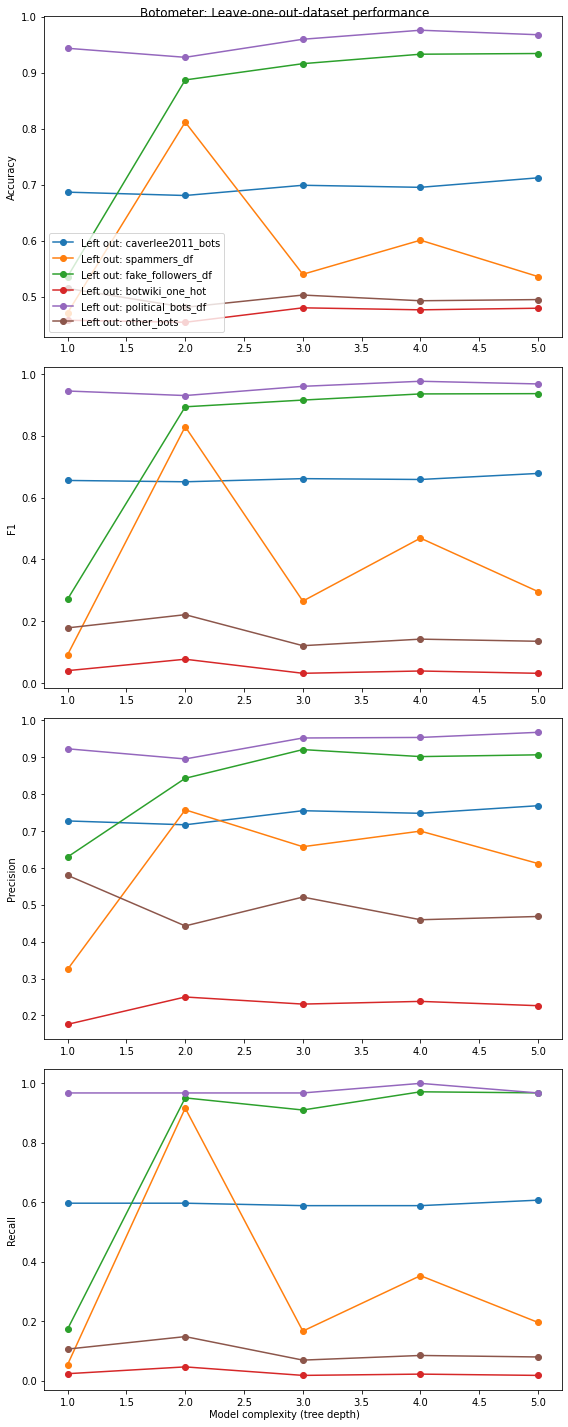

In [657]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer: Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

# Ensemble of specialized decision trees

In [658]:
def split_human_df(human_df, n_datasets, dataset_size):
    human_df_sample = human_df.sample(n=n_datasets*dataset_size)
    return [human_df_sample[i*dataset_size:(i+1)*dataset_size] for i in range(n_datasets)]

In [659]:
DEPTH = 4
def get_bot_classifier(bots, humans, dataset_size, cols, test_aggregate, test_labels_aggregate, method=None):
    dataset_size = min(len(bots), len(humans))
    n=min(dataset_size, dataset_size)

    X = pd.concat([bots.sample(n=n)[cols], humans.sample(n=n)[cols]])
    y = [1] * n + [0] * n

    X = X.fillna(0)
    train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.05)
    test_aggregate.append(test)
    test_labels_aggregate.append(test_labels)

    scores = {
        'dataset': get_dataset_name(bots),
    }

    clf, *_ = fit_and_score(train, train_labels, method=method, depth=DEPTH, silent=True)
    return clf

def get_confidence(value, i):
    pair = value[i][0]
    return max(pair)/sum(pair)

def get_class(value, i):
    pair = value[i][0]
    return np.argmax(pair)

def get_max_confidence(confidences, i):
    conf_i = [confidences[j][i] for j in range(n_classifiers)]
    return np.argmax(conf_i), max(conf_i)

def get_max_confidence_pred(predictions, confidences, i):
    argmaximum, maximum = get_max_confidence(confidences, i)
    return predictions[argmaximum][i]
    
def get_majority_vote(predictions, i):
    preds_i = [predictions[j][i] for j in range(n_classifiers)]
    majority = sum(preds_i)/len(botometer_datasets)
    return 1 if majority >= 1/2 else 0

def get_weighted_majority_vote(predictions, confidences, i):
    conf_i = [confidences[j][i] for j in range(n_classifiers)]
    preds_i = [2*predictions[j][i]-1 for j in range(n_classifiers)]
    weights = [conf_i[j] * preds_i[j] for j in range(n_classifiers)]
    return 1 if sum(weights) > 0 else 0

def get_max_captured(value, i):
    pair = value[i][0]
    return max(pair)

def get_max_captured_multiclassifier(predictions, captured, i):
    return get_max_confidence_pred(predictions, captured, i)


In [660]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
human_dfs = split_human_df(human_df, len(botometer_datasets), dataset_size)

cols = set.intersection(
    *[set(b.columns) for b in botometer_datasets],
    set(human_df.columns)
)
if 'created_at' in cols:
    cols.remove('created_at')
cols = list(cols)

def get_ensemble_of_classifiers(method=None):
    test_aggregate = []
    test_labels_aggregate = []
    dataset_size = 1200

    clfs = [get_bot_classifier(bots, humans, dataset_size, cols, test_aggregate, test_labels_aggregate, method=method) for bots, humans in zip(botometer_datasets, human_dfs)]
    test_aggregate_df = pd.concat(test_aggregate)
    test_labels_aggregate_concat = np.concatenate(test_labels_aggregate)

    # make human classifier
    test_all = []
    test_all_labels = []
    all_bots = pd.concat([d[cols] for d in botometer_datasets])
    all_clf = get_bot_classifier(all_bots, human_df, min(len(all_bots), len(human_df)), cols, test_all, test_all_labels, method=method)
    test_all = test_all[0]
    test_all_labels = test_all_labels[0]

    clfs = clfs + [all_clf]
    test_aggregate_df = pd.concat([test_aggregate_df, test_all])
    test_labels_aggregate_concat = np.concatenate([test_labels_aggregate_concat, test_all_labels])
    
    return clfs, test_aggregate_df, test_labels_aggregate_concat

In [661]:
for d in botometer_datasets:
    print(get_dataset_name(d), len(d))

caverlee2011_bots 22223
spammers_df 25425
fake_followers_df 4438
botwiki_one_hot 698
political_bots_df 62
other_bots 8684


In [662]:
clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers()
n_classifiers = len(clfs)

captured = [list(map(lambda j: get_max_captured(clfs[i].tree_.value, j), clfs[i].apply(test_aggregate_df))) for i in range(n_classifiers)]
confidences = [list(map(lambda j: get_confidence(clfs[i].tree_.value, j), clfs[i].apply(test_aggregate_df))) for i in range(n_classifiers)]
predictions = [clfs[i].predict(test_aggregate_df) for i in range(n_classifiers)]

max_confidences = [get_max_confidence_pred(predictions, confidences, i) for i in range(len(test_aggregate_df))]
majority_votes = [get_majority_vote(predictions, i) for i in range(len(test_aggregate_df))]
weighted_majority_votes = [get_weighted_majority_vote(predictions, confidences, i) for i in range(len(test_aggregate_df))]

print(f"Accuracy using max confidences: {accuracy_score(max_confidences, test_labels_aggregate_concat)}")
print(f"Accuracy using majority vote: {accuracy_score(majority_votes, test_labels_aggregate_concat)}")
print(f"Accuracy using weighted majority vote: {accuracy_score(weighted_majority_votes, test_labels_aggregate_concat)}")
print(f"F1 using max confidences: {f1_score(max_confidences, test_labels_aggregate_concat)}")
print(f"F1 using majority votes: {f1_score(majority_votes, test_labels_aggregate_concat)}")
print(f"F1 using weighted majority votes: {f1_score(weighted_majority_votes, test_labels_aggregate_concat)}")

most_captured = [get_max_captured_multiclassifier(predictions, captured, i) for i in range(len(test_aggregate_df))]
weighted_majority_captured = [get_weighted_majority_vote(predictions, captured, i) for i in range(len(test_aggregate_df))]

print(f"Accuracy using most captured: {accuracy_score(most_captured, test_labels_aggregate_concat)}")
print(f"Accuracy using weighted most captured: {accuracy_score(weighted_majority_captured, test_labels_aggregate_concat)})")

print(f"F1 using most captured: {f1_score(most_captured, test_labels_aggregate_concat)}")
print(f"F1 using weighted majority captured: {f1_score(weighted_majority_captured, test_labels_aggregate_concat)}")


Accuracy using max confidences: 0.626875699888018
Accuracy using majority vote: 0.8022396416573349
Accuracy using weighted majority vote: 0.6636058230683091
F1 using max confidences: 0.429061000685401
F1 using majority votes: 0.7796356376341402
F1 using weighted majority votes: 0.5101108936725376
Accuracy using most captured: 0.8206047032474804
Accuracy using weighted most captured: 0.8208286674132139)
F1 using most captured: 0.8174982911825016
F1 using weighted majority captured: 0.8176845943482224


## Ensembles of specialized random forests

In [663]:
def get_max_confidence_rf(probabilities, i):
    conf_i = [probabilities[j][i] for j in range(n_classifiers)]
    conf_i[-1] = 1 - conf_i[-1]
    return np.argmax(conf_i), max(conf_i)

rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(rf)

predictions = [rf_clfs[i].predict(test_aggregate_df) for i in range(n_classifiers)]
probs = [rf_clfs[i].predict_proba(test_aggregate_df) for i in range(n_classifiers)]
probs = [p[:,0] for p in probs]
most_confident_clf = [get_max_confidence_rf(probs, i)[0] for i in range(len(test_aggregate_df))]
max_prediction = [predictions[j][i] for i,j in enumerate(most_confident_clf)]
print(f"Accuracy: {accuracy_score(max_prediction, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(max_prediction, test_labels_aggregate_concat)}")

Accuracy: 0.5827547592385218
F1: 0.2831858407079646


## Just simple decision rule

In [664]:
all_clf = clfs[-1]
all_predictions = all_clf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions, test_labels_aggregate_concat)}")

Accuracy: 0.8176931690929451
F1: 0.815


## Just random forest

In [666]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions_rf, test_labels_aggregate_concat)}")

Accuracy: 0.8716685330347145
F1: 0.8689686713926367


# Plotting performance of network stats on single plot

In [104]:
scores_dict = {
    "twibot": {
        'c': 'C0',
        "a": 0.8664, #accuracy
        "p": 0.8256, #precision
        "r": 0.8657, #recall
        'scores': twibot_scores
    },
    "botometer-feedback-2019": {
        'c': 'C1',
        'a': 0.81,
        "p": 0.84,
        "r": 0.7,
        'num_bots': 139,
        'num_humans': 380,
        'scores': botometer_feedback_scores
    },
    "rtbust": {
        'c': 'C2',        
        "a": 0.8755,
        'p': 0.9304,
        'r': 0.9512,
        'scores': rtbust_scores
    },
    "midterm-2018": {
        'c': 'C3',
        "a": 0.987,
        'p': 0.989,
        'r': 0.995,
        'scores': midterm_scores
    },
    "gilani": {
        'c': 'C4',
        "a": 0.8644,
        'p': 0.854,
        'r': 0.822,
        'scores': gilani_derived_scores_avg
    },
    "cresci-2017": {
        'c': 'C5',
        'a': 0.9871,
        'p': 0.98,
        'r': 0.98,
        'scores': cresci2017_scores
    },
    "cresci-2015": {
        'c': 'C6',
        "a": 0.991,
        'p': 0.994,
        'r': 0.991,
        'scores': cresci2015_scores
    },
    "caverlee-2011": {
        'c': 'C6',
        'a': 0.9826,
        'p': 0.89,
        'r': 0.87,
        'num_bots': 19276,
        'num_humans': 22223,
        'scores': caverlee2011_scores
    },
    'pan19': {
        'c': 'C7',
        'f': 0.95,
        'a': 0.95,
        'scores': pan19_scores
    },
    'cresci-2017 tweets': {
        'c': 'C8',
        'a': 0.976,
        'p': 1,
        'r': 0.95,
        'scores': pan19_scores
    },
    'yang-2013': {
        'c': 'C9',
        'a': 0.98,
        'p': 0.96,
        'r': 0.85,
        'scores': yang_scores
    }
}
metric_names = ['accuracy', 'F1', 'precision', 'recall']

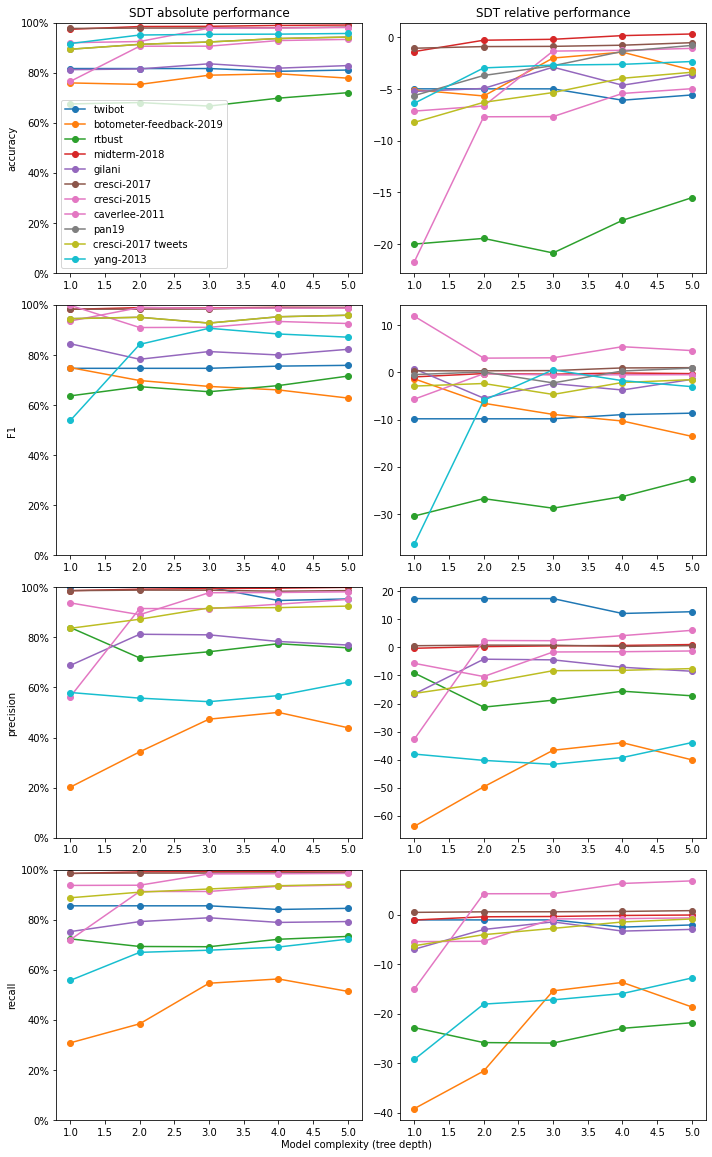

In [105]:
fig, axes = plt.subplots(4,2, figsize=(10, 16))

for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
        if i == 0:
            if 'a' not in d:
                continue
            soa_score = d['a']
        if i == 1:
            if 'f' not in d:
                d['f'] = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])
            soa_score = d['f']
        if i == 2:
            if 'p' not in d:
                continue
            soa_score = d['p']
        if i == 3:
            if 'r' not in d:
                continue
            soa_score = d['r']
        metric_i = [item[i]*100 for item in d['scores']]
        axes[i][0].plot(range(1,6), metric_i, label=name, marker="o", color=d['c'])
        metric_i_relative = [(item[i]-soa_score)*100 for item in d['scores']]
        axes[i][1].plot(range(1,6), metric_i_relative, label=name, marker="o", color=d['c'])
        metric_i_max = max([item[i] for item in d['scores']])
        delta_i = metric_i_max - soa_score
        d["sdt_"+metric_name] = metric_i_max
        d["sdt_delta_"+metric_name] = delta_i
    axes[i][0].set_ylabel(metric_name)
    axes[i][0].set_ylim((0,100))
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i][0].yaxis.set_major_formatter(yticks)
axes[0][0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
axes[0][0].set_title("SDT absolute performance")
axes[0][1].set_title("SDT relative performance")
fig.tight_layout()
plt.show()

score_df = pd.DataFrame.from_dict(scores_dict, orient="index")
score_df.to_csv("bot_detection_scores.csv")

In [106]:
score_df

,c,a,p,r,scores,sdt_accuracy,sdt_delta_accuracy,f,sdt_F1,sdt_delta_F1,sdt_precision,sdt_delta_precision,sdt_recall,sdt_delta_recall,num_bots,num_humans
twibot,C0,0.8664,0.8256,0.8657,"[(0.8165680473372781, 0.7467911318553092, 1.0,...",0.816568,-0.049832,0.845175,0.758706,-0.086468,1.000000,0.174400,0.855043,-0.010657,NaN,NaN
botometer-feedback-2019,C1,0.8100,0.8400,0.7000,"[[0.7592046303211353, 0.7496732026143791, 0.20...",0.795743,-0.014257,0.763636,0.749673,-0.013963,0.500229,-0.339771,0.563034,-0.136966,139.0,380.0
rtbust,C2,0.8755,0.9304,0.9512,"[[0.6753347686814053, 0.6368232919629185, 0.83...",0.720233,-0.155267,0.940685,0.715711,-0.224974,0.839099,-0.091301,0.732820,-0.218380,NaN,NaN
midterm-2018,C3,0.9870,0.9890,0.9950,"[(0.9732884843688168, 0.9821847163619315, 0.98...",0.990305,0.003305,0.991991,0.990406,-0.001585,0.999408,0.010408,0.994229,-0.000771,NaN,NaN
gilani,C4,0.8644,0.8540,0.8220,"[[0.8120704261457423, 0.8449418148178527, 0.68...",0.835580,-0.028820,0.837695,0.844942,0.007247,0.812139,-0.041861,0.807343,-0.014657,NaN,NaN
cresci-2017,C5,0.9871,0.9800,0.9800,"[[0.976614755671344, 0.9829805884415613, 0.986...",0.981974,-0.005126,0.980000,0.989687,0.009687,0.988337,0.008337,0.988094,0.008094,NaN,NaN
cresci-2015,C6,0.9910,0.9940,0.9910,"[[0.9196306299638779, 0.9356570480014884, 0.93...",0.980382,-0.010618,0.992498,0.989365,-0.003132,0.981513,-0.012487,0.984440,-0.006560,NaN,NaN
caverlee-2011,C6,0.9826,0.8900,0.8700,"[[0.7653680004994069, 0.9981723488283671, 0.56...",0.932914,-0.049686,0.879886,0.998172,0.118286,0.951077,0.061077,0.938195,0.068195,19276.0,22223.0
pan19,C7,0.9500,NaN,NaN,"[[0.8936910569105692, 0.9451030878283099, 0.83...",0.942235,-0.007765,0.950000,0.958715,0.008715,NaN,NaN,NaN,NaN,NaN,NaN
cresci-2017 tweets,C8,0.9760,1.0000,0.9500,"[[0.8936910569105692, 0.9451030878283099, 0.83...",0.942235,-0.033765,0.974359,0.958715,-0.015644,0.924609,-0.075391,0.941232,-0.008768,NaN,NaN


In [107]:
score_df = pd.read_csv('bot_detection_scores.csv')

In [108]:
score_df[['Unnamed: 0', 'sdt_delta_F1']]

,Unnamed: 0,sdt_delta_F1
0,twibot,-0.086468
1,botometer-feedback-2019,-0.013963
2,rtbust,-0.224974
3,midterm-2018,-0.001585
4,gilani,0.007247
5,cresci-2017,0.009687
6,cresci-2015,-0.003132
7,caverlee-2011,0.118286
8,pan19,0.008715
9,cresci-2017 tweets,-0.015644


In [109]:
score_df['sdt_delta_F1']

0    -0.086468
1    -0.013963
2    -0.224974
3    -0.001585
4     0.007247
5     0.009687
6    -0.003132
7     0.118286
8     0.008715
9    -0.015644
10    0.005088
Name: sdt_delta_F1, dtype: float64